In [1]:
#Necessary libraries
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101
from sklearn.metrics import f1_score, precision_score, recall_score
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Class definition
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir)) if mask_dir else None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.masks:
            mask_path = os.path.join(self.mask_dir, self.masks[idx])
            mask = Image.open(mask_path).convert("L")
            mask = (to_tensor(mask) > 0.5).int()
            return image, mask
        else:
            return image

# Converting images to tensors and normalizing them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard ImageNet normalization
])

#Loading data from drive
image_dir = '/content/drive/MyDrive/preproccessed roadseg NO NOISE/images'
mask_dir = '/content/drive/MyDrive/preproccessed roadseg NO NOISE/masks'

#Creating the dataset
dataset = RoadSegmentationDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    transform=transform
)

#Defining the splitting ratios (e.g., 70% training, 15% validation, 15% testing)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

#Data split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)  # Test loader added

In [4]:
# Visualizing a sample
#Checking
for images, masks in train_loader:
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)
    print(masks[0])
    break

Image batch shape: torch.Size([4, 3, 512, 512])
Mask batch shape: torch.Size([4, 1, 512, 512])
tensor([[[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int32)


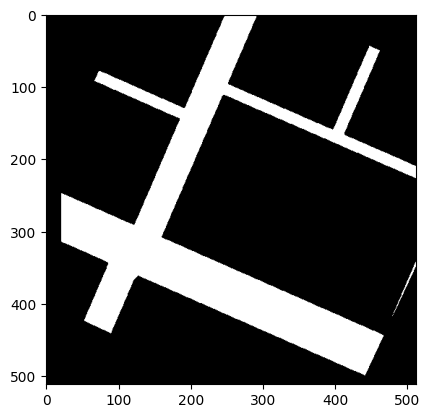

In [5]:
#Checking
plt.imshow(train_dataset[7][1].permute(1,2,0), cmap='gray')

In [6]:
#Loading the model and modifying the classifier for binary segmentation
num_classes = 1

deeplabv3_plus = deeplabv3_resnet101(weights="DEFAULT")
# The 'classifier' includes a Conv2D layer at the end which we modify
deeplabv3_plus.classifier[4] = torch.nn.Conv2d(
    in_channels=256,
    out_channels=num_classes,
    kernel_size=(1, 1),
    stride=(1, 1))


# Ensure the model weights are reinitialized for the new classifier
torch.nn.init.xavier_normal_(deeplabv3_plus.classifier[4].weight)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 174MB/s]


Parameter containing:
tensor([[[[ 1.4819e-01]],

         [[ 1.0837e-02]],

         [[ 1.9603e-03]],

         [[-8.2239e-02]],

         [[-3.8627e-02]],

         [[-1.0052e-01]],

         [[ 2.0558e-01]],

         [[-4.2416e-02]],

         [[-3.2100e-02]],

         [[-5.4505e-02]],

         [[-8.1964e-02]],

         [[-9.5278e-03]],

         [[ 1.3611e-01]],

         [[-5.3561e-02]],

         [[ 2.7483e-02]],

         [[ 1.7974e-01]],

         [[-1.4912e-02]],

         [[-1.8810e-01]],

         [[ 1.2337e-01]],

         [[-3.3890e-02]],

         [[-4.7691e-02]],

         [[ 5.1286e-02]],

         [[ 1.6233e-01]],

         [[-2.9595e-02]],

         [[-2.1383e-03]],

         [[ 3.7744e-03]],

         [[-1.2531e-01]],

         [[-1.2805e-01]],

         [[ 6.9888e-02]],

         [[-7.9148e-02]],

         [[-1.2201e-01]],

         [[-6.1545e-02]],

         [[ 1.5350e-01]],

         [[-8.9732e-02]],

         [[ 5.3250e-02]],

         [[-1.0363e-01]],

      

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = deeplabv3_plus.to(device)

# ComboLoss definition
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + 1) / (inputs.sum() + targets.sum() + 1)
        return 1 - dice

class ComboLoss(torch.nn.Module):
    def __init__(self):
        super(ComboLoss, self).__init__()

    def forward(self, inputs, targets):
        bce = torch.nn.BCEWithLogitsLoss()(inputs, targets)
        dice = DiceLoss()(inputs, targets)
        return bce + dice

# Function to plot loss and F1 metrics
def plot_metrics(loss_history, f1_history):
    plt.figure(figsize=(10, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label="Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(f1_history, label="F1 Score", color="orange")
    plt.title("F1 Score over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.show()

# F1 Score Calculation
def calculate_f1_score(y_true, y_pred):
    y_true = y_true.flatten() > 0.5
    y_pred = y_pred.flatten() > 0.5
    return {
        "background": f1_score(y_true, y_pred),
        "road": f1_score(y_true, y_pred),
        "average": f1_score(y_true, y_pred),
    }

<ipython-input-8-6f5f4fefbde8>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-8-6f5f4fefbde8>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision forward pass


Batch 0: Loss = 0.3471
Batch 10: Loss = 0.3410
Batch 20: Loss = 0.3418
Batch 30: Loss = 0.3121
Batch 40: Loss = 0.3055
Batch 50: Loss = 0.3060
Batch 60: Loss = 0.2775
Batch 70: Loss = 0.3200
Batch 80: Loss = 0.2553
Epoch [1/10], Loss: 0.3023, F1 Score: 0.3749
Best model saved with F1-score: 0.3749


<ipython-input-8-6f5f4fefbde8>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision forward pass


Batch 0: Loss = 0.2377
Batch 10: Loss = 0.2370
Batch 20: Loss = 0.2437
Batch 30: Loss = 0.2256
Batch 40: Loss = 0.2362
Batch 50: Loss = 0.2156
Batch 60: Loss = 0.2393
Batch 70: Loss = 0.1831
Batch 80: Loss = 0.2296
Epoch [2/10], Loss: 0.2276, F1 Score: 0.6679
Best model saved with F1-score: 0.6679
Model saved at epoch 2


<ipython-input-8-6f5f4fefbde8>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision forward pass


Batch 0: Loss = 0.1676
Batch 10: Loss = 0.1986
Batch 20: Loss = 0.1922
Batch 30: Loss = 0.1993
Batch 40: Loss = 0.1747
Batch 50: Loss = 0.1933
Batch 60: Loss = 0.1510
Batch 70: Loss = 0.1746
Batch 80: Loss = 0.1575
Epoch [3/10], Loss: 0.1732, F1 Score: 0.7535
Best model saved with F1-score: 0.7535


<ipython-input-8-6f5f4fefbde8>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision forward pass


Batch 0: Loss = 0.1518
Batch 10: Loss = 0.1256
Batch 20: Loss = 0.1124
Batch 30: Loss = 0.1155
Batch 40: Loss = 0.1719
Batch 50: Loss = 0.1173
Batch 60: Loss = 0.1210
Batch 70: Loss = 0.1195
Batch 80: Loss = 0.1617
Epoch [4/10], Loss: 0.1358, F1 Score: 0.8032
Best model saved with F1-score: 0.8032
Model saved at epoch 4


<ipython-input-8-6f5f4fefbde8>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision forward pass


Batch 0: Loss = 0.1552
Batch 10: Loss = 0.1125
Batch 20: Loss = 0.1325
Batch 30: Loss = 0.1076
Batch 40: Loss = 0.1191
Batch 50: Loss = 0.1162
Batch 60: Loss = 0.1000
Batch 70: Loss = 0.1145
Batch 80: Loss = 0.1284
Epoch [5/10], Loss: 0.1091, F1 Score: 0.8397
Best model saved with F1-score: 0.8397


<ipython-input-8-6f5f4fefbde8>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision forward pass


Batch 0: Loss = 0.0650
Batch 10: Loss = 0.0694
Batch 20: Loss = 0.0807
Batch 30: Loss = 0.0901
Batch 40: Loss = 0.0892
Batch 50: Loss = 0.1224
Batch 60: Loss = 0.0961
Batch 70: Loss = 0.0671
Batch 80: Loss = 0.0717
Epoch [6/10], Loss: 0.0931, F1 Score: 0.8622
Best model saved with F1-score: 0.8622
Model saved at epoch 6


<ipython-input-8-6f5f4fefbde8>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision forward pass


Batch 0: Loss = 0.0784
Batch 10: Loss = 0.0809
Batch 20: Loss = 0.0905
Batch 30: Loss = 0.0835
Batch 40: Loss = 0.0724
Batch 50: Loss = 0.0694
Batch 60: Loss = 0.0987
Batch 70: Loss = 0.0724
Batch 80: Loss = 0.0819
Epoch [7/10], Loss: 0.0807, F1 Score: 0.8807
Best model saved with F1-score: 0.8807


<ipython-input-8-6f5f4fefbde8>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision forward pass


Batch 0: Loss = 0.0846
Batch 10: Loss = 0.0678
Batch 20: Loss = 0.0591
Batch 30: Loss = 0.0645
Batch 40: Loss = 0.0825
Batch 50: Loss = 0.0814
Batch 60: Loss = 0.0717
Batch 70: Loss = 0.0662
Batch 80: Loss = 0.0653
Epoch [8/10], Loss: 0.0730, F1 Score: 0.8910
Best model saved with F1-score: 0.8910
Model saved at epoch 8


<ipython-input-8-6f5f4fefbde8>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision forward pass


Batch 0: Loss = 0.0553
Batch 10: Loss = 0.0817
Batch 20: Loss = 0.0499
Batch 30: Loss = 0.0648
Batch 40: Loss = 0.0609
Batch 50: Loss = 0.0670
Batch 60: Loss = 0.0688
Batch 70: Loss = 0.0607
Batch 80: Loss = 0.0633
Epoch [9/10], Loss: 0.0659, F1 Score: 0.9021
Best model saved with F1-score: 0.9021


<ipython-input-8-6f5f4fefbde8>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision forward pass


Batch 0: Loss = 0.0475
Batch 10: Loss = 0.0572
Batch 20: Loss = 0.0524
Batch 30: Loss = 0.0696
Batch 40: Loss = 0.0467
Batch 50: Loss = 0.0431
Batch 60: Loss = 0.0923
Batch 70: Loss = 0.0600
Batch 80: Loss = 0.0446
Epoch [10/10], Loss: 0.0595, F1 Score: 0.9116
Best model saved with F1-score: 0.9116
Model saved at epoch 10
Training time: 38.21 minutes
Final model saved.
Best F1 Score: 0.9116


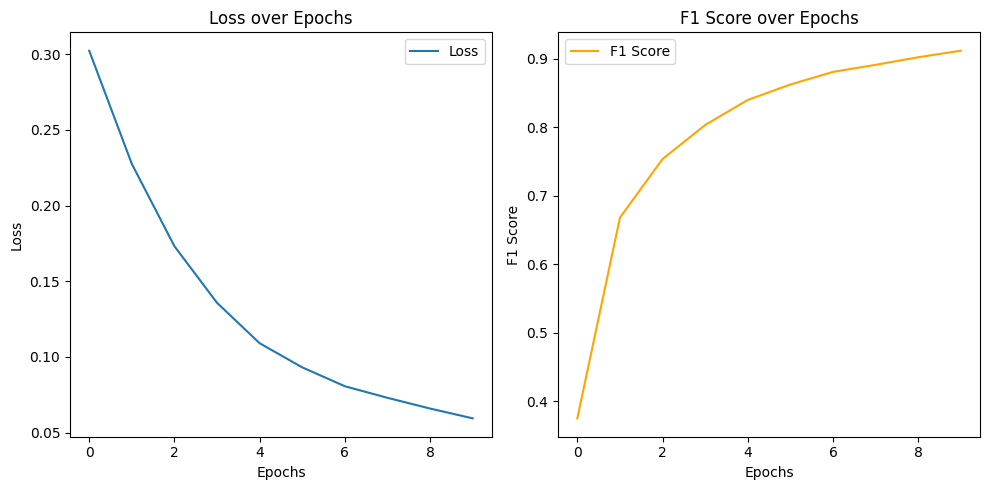

In [8]:
# Initialization
criterion = ComboLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()

epochs = 10
accumulation_steps = 4
best_f1 = 0.0
saving_interval = 2  # Save model every 2 epochs
model_dir = "/content/model/"
os.makedirs(model_dir, exist_ok=True)

best_model_path = os.path.join(model_dir, "best_model.pt")
model_path = os.path.join(model_dir, "last_model.pt")

loss_history = []
f1_history = []

# Start training
time2 = time.time()
for epoch in range(epochs):
    model.train()
    epoch_losses = []
    all_targets, all_predictions = [], []

    epoch_loss = 0
    for i, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device).float()

        with autocast():  # Mixed precision forward pass
            outputs = model(images)["out"]
            loss = criterion(outputs, masks) / accumulation_steps

        # Backward pass with gradient accumulation
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        # Accumulate loss and predictions
        epoch_losses.append(loss.item())
        epoch_loss += loss.item()

        predictions = (outputs > 0.5).float()
        all_targets.append(masks.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

        if i % 10 == 0:  # Print progress every 10 batches
            print(f"Batch {i}: Loss = {loss.item():.4f}")

    # Calculate average epoch loss and F1 score
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)

    f1_scores = calculate_f1_score(all_targets, all_predictions)
    avg_f1 = f1_scores["average"]

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, F1 Score: {avg_f1:.4f}")
    loss_history.append(avg_loss)
    f1_history.append(avg_f1)

    # Save the best model
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with F1-score: {best_f1:.4f}")

    # Save model at intervals
    if (epoch + 1) % saving_interval == 0:
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at epoch {epoch + 1}")

time1 = time.time()
total_time = (time1 - time2) / 60
print(f"Training time: {total_time:.2f} minutes")

# Final save and training completion
torch.save(model.state_dict(), model_path)
print("Final model saved.")
print(f"Best F1 Score: {best_f1:.4f}")

# Plot loss and F1 metrics
plot_metrics(loss_history, f1_history)

In [9]:
# Validation loop
model.eval()
with torch.no_grad():
    val_loss = 0
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device).float()
        with autocast():  # Mixed precision forward pass
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    print(f"Validation Loss: {val_loss:.4f}")

<ipython-input-9-6e727616b75e>:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision forward pass


Validation Loss: 5.6843


In [ ]:
# Function to calculate F1 score, precision, and recall for the dataset
def compute_metrics(preds, targets, num_classes):
    preds = preds.flatten() > 0.5
   # print(preds)
    targets = targets.flatten()

    # Ensure valid range
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy() > 0.5
   # print(targets)

    metrics = {
        "f1": f1_score(targets, preds),
        "precision": precision_score(targets, preds),
        "recall": recall_score(targets, preds),
    }
    return metrics

# Evaluation loop
model.eval()
all_metrics = {"f1": [], "precision": [], "recall": []}
num_classes = 1  # Update based on the number of classes
visualized = False  # Flag to control single visualization

with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)["out"]
        preds = outputs.reshape(-1, 512, 512, 1)  # Predicted masks

        # Compute metrics for this batch
        batch_metrics = compute_metrics(preds, masks, num_classes=num_classes)
        for key in all_metrics.keys():
            all_metrics[key].append(batch_metrics[key])

        # Visualization for the first batch only
        if not visualized:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.title("Input Image")
            plt.imshow(to_pil_image(images[0].cpu()))

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(masks[0].cpu().permute(1, 2, 0), cmap="gray")

            plt.subplot(1, 3, 3)
            plt.title("Prediction")
            plt.imshow(preds[0].cpu(), cmap="gray")

            plt.show()
            visualized = True  # Set the flag to True to avoid further visualizations

# Aggregate and print final metrics
final_metrics = {key: np.mean(values) for key, values in all_metrics.items()}
print("Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

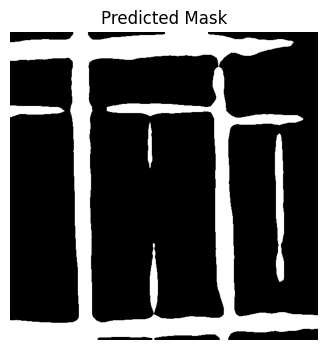

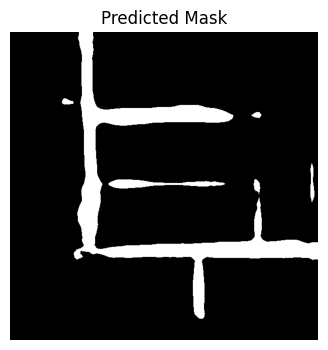

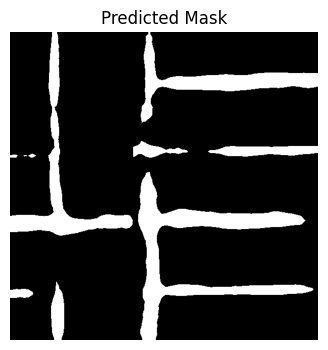

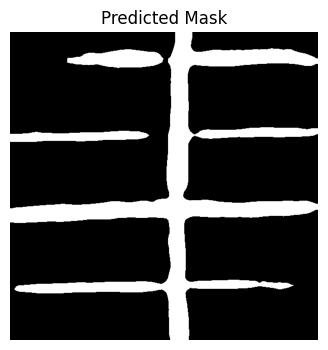

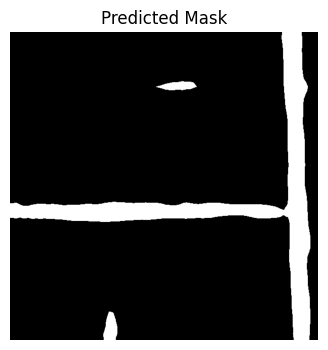

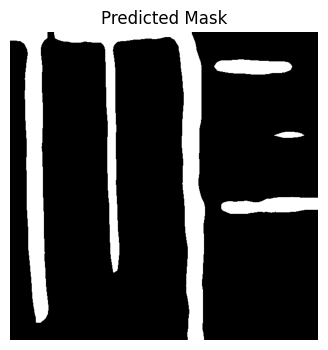

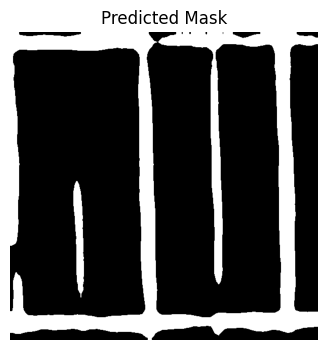

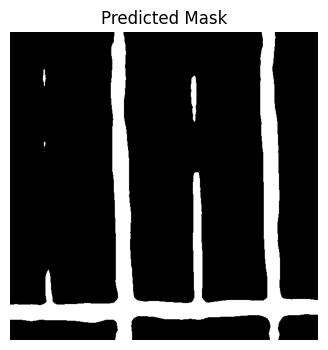

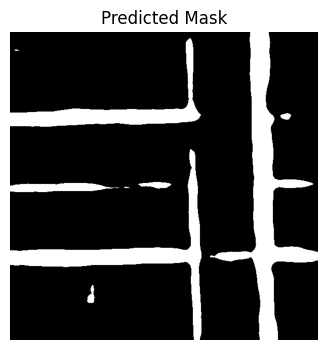

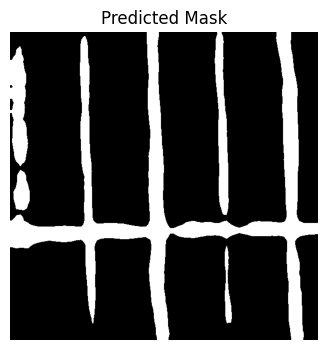

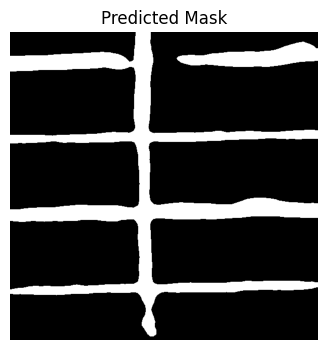

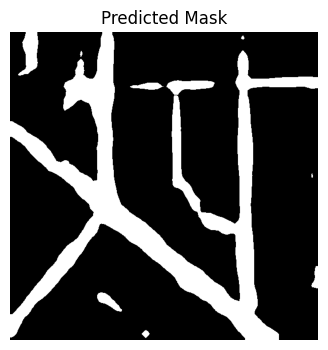

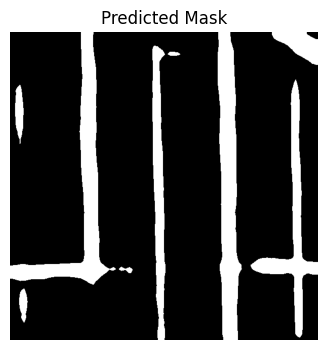

In [11]:
#Testing on unseen data
unseen_image_dir = '/content/drive/MyDrive/test set/testing'
unseen_dataset = RoadSegmentationDataset(image_dir=unseen_image_dir, transform=transform)  # No mask_dir provided
unseen_loader = DataLoader(unseen_dataset, batch_size=4, shuffle=False)

#Generating predictions
unseen_predictions = []
model.eval()
with torch.no_grad():
    for images in unseen_loader:
        images = images.to(device)
        outputs = model(images)["out"]
        preds = torch.sigmoid(outputs) > 0.5  #Applying threshold to get binary masks
        unseen_predictions.append(preds.cpu())

#Visualization of predictions
for batch in unseen_predictions:
    for pred in batch:
        plt.figure(figsize=(4, 4))
        plt.title("Predicted Mask")
        plt.imshow(pred.squeeze().numpy(), cmap="gray")
        plt.axis("off")
        plt.show()
        break